In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

### Data: https://www.kaggle.com/competitions/bike-sharing-demand/data

In [2]:
data = pd.read_csv('./data/train.csv')

In [3]:
df = data.copy()

In [4]:
df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


### Time Series Analysis

In [7]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):

    #decomposing a sample of the time series
    res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    decomposed = [res.observed, res.trend, res.seasonal, res.resid]
    titles = ['OBSERVED','TREND','SEASONALITY','NOISE']    
    plot_id = range(0,4)
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    
    # Observed: plot the complete time series
    # Trend: plot the trend of the time series
    # Seasonality: plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality
    # Noise: plot the noise of the time series
    for p_id, title, res in zip(plot_id, titles, decomposed):        
        axs[p_id].set_title(title, fontsize=16)
        axs[p_id].plot(res)
        
        if p_id == 3:
            axs[p_id].scatter(y=res, x=range(len(res)), alpha=0.5)
        
        axs[p_id].grid()
    
    plt.show()

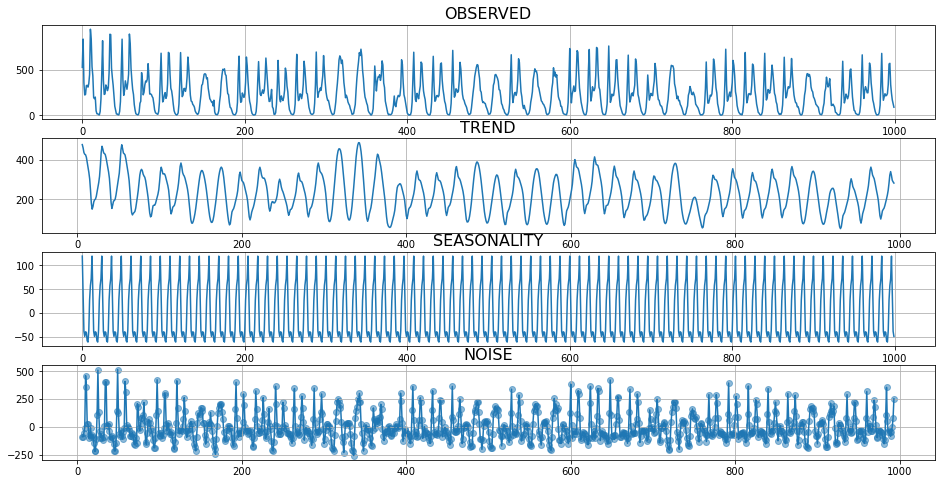

In [8]:
# sample_size = df.shape[0] use for all samples
decompose_bike_sharing_demand(df, samples=1000, period=12)

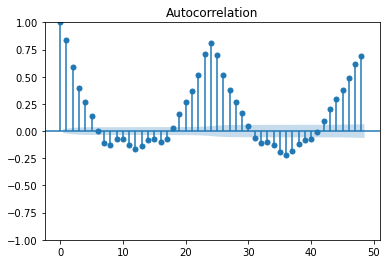

<Figure size 1152x432 with 0 Axes>

In [9]:
plot_acf(df['count'].values, lags=48)
fig = plt.figure(figsize=(16,6))
plt.show()

### Data Preparation

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df.datetime)

#drop datetime column
df.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month

#drop casual and registered columns
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [11]:
df.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,5,1,1
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,6,1,1
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,3,7,1,1
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8,8,1,1


### Outliers Analysis

### 1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" 

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

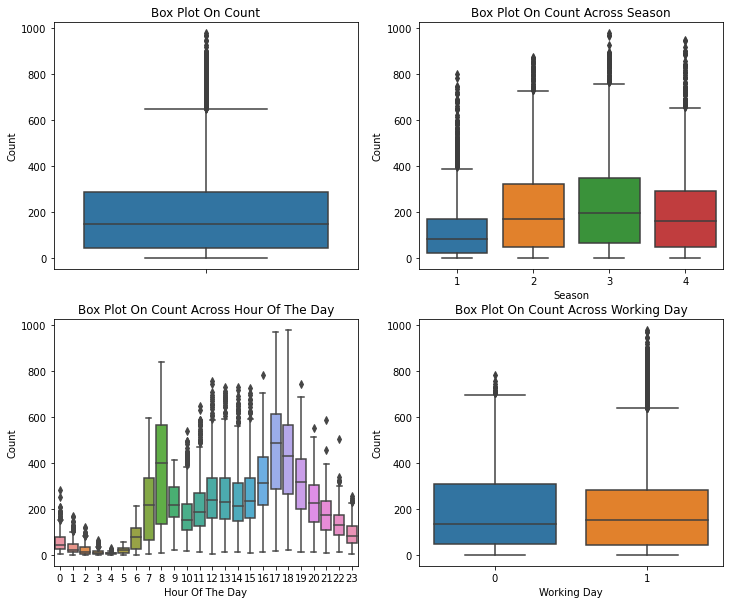

In [24]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

### Correlation Analysis

<AxesSubplot:>

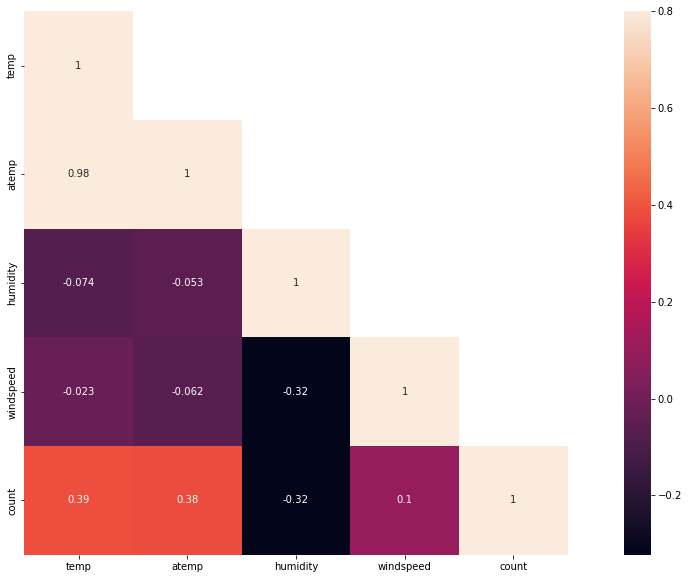

In [27]:
corrMatt = df[["temp","atemp","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

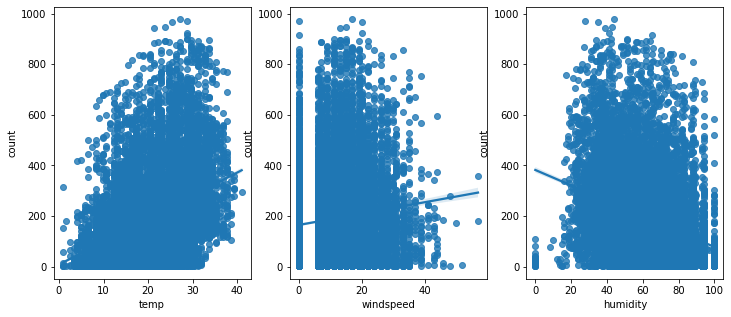

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df,ax=ax2)
sns.regplot(x="humidity", y="count", data=df,ax=ax3)

### Data Distribution

/home/lselvera/anaconda3/envs/timeseries/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lselvera/anaconda3/envs/timeseries/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82771489, -3.60351126, -3.48046578, ...,  3.48046578,
          3.60351126,  3.82771489]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.358228768511217, 4.609101346914844, 0.9602874864703482))

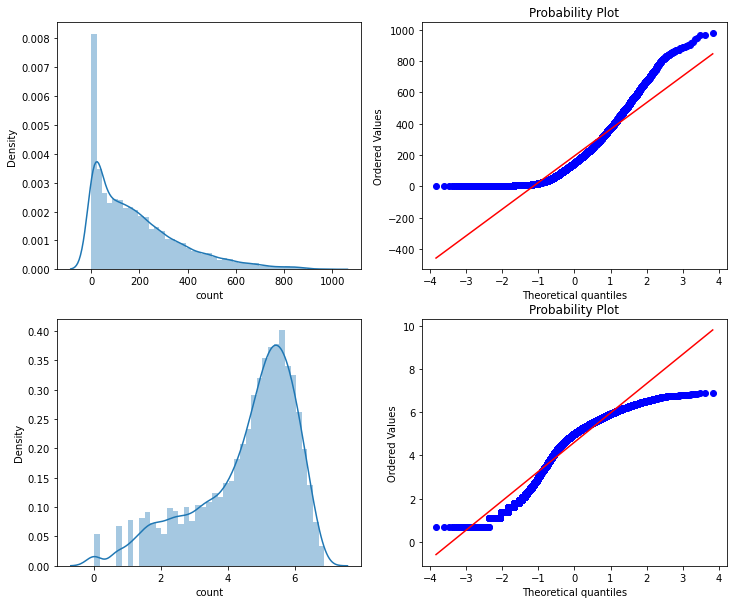

In [33]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(df["count"],ax=axes[0][0])
stats.probplot(df["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(df["count"]),ax=axes[1][0])
stats.probplot(np.log1p(df["count"]), dist='norm', fit=True, plot=axes[1][1])

### Time Series Modelling: LightGBM (Light Gradient Boosting Machine)

In [12]:
def train(df, horizon=24*7):
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    return mae, y_test, predictions, model

In [13]:
def plot_results(mae, y_test, predictions):
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()    
    
    return

In [14]:
def plot_variable_importance(model):
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    fig = plt.figure(figsize=(16,6))
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()    

### Training

In [15]:
mae, y_test, predictions, model = train(df)

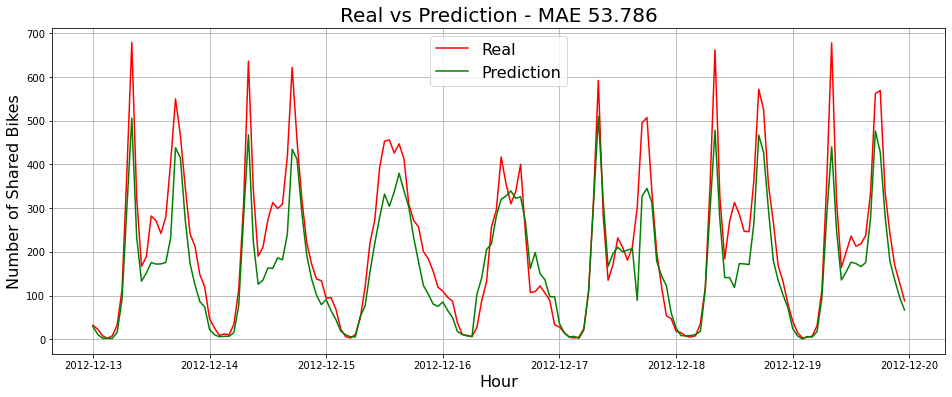

In [16]:
plot_results(mae, y_test, predictions)

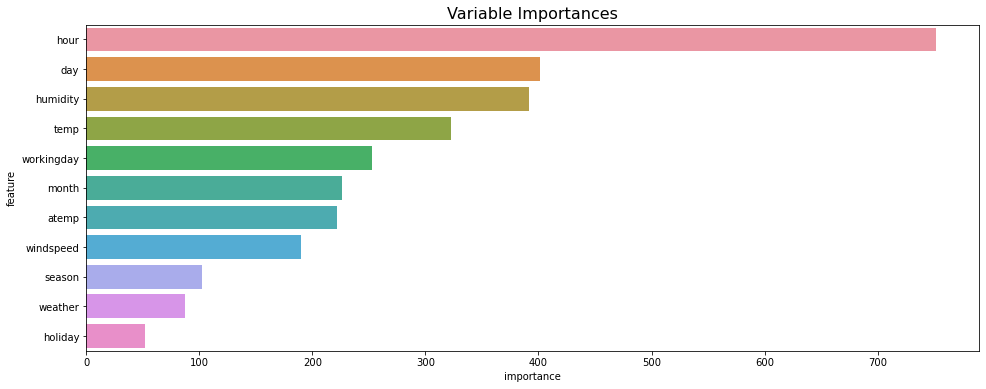

In [17]:
plot_variable_importance(model)

### Training with lags

In [18]:
#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['count'].shift(24*7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

In [19]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,count_prev_week_same_hour
datetime,,,,,,,,,,,,,
2011-01-08 07:00:00,1,0,0,2,6.56,9.09,74,7.0015,9,7,8,1,16.0
2011-01-08 08:00:00,1,0,0,3,6.56,9.09,93,7.0015,15,8,8,1,40.0
2011-01-08 09:00:00,1,0,0,3,6.56,9.09,93,7.0015,20,9,8,1,32.0
2011-01-08 10:00:00,1,0,0,2,7.38,9.85,80,11.0014,61,10,8,1,13.0
2011-01-08 11:00:00,1,0,0,2,8.20,9.09,69,26.0027,62,11,8,1,1.0


In [20]:
mae, y_test, predictions, model = train(df)

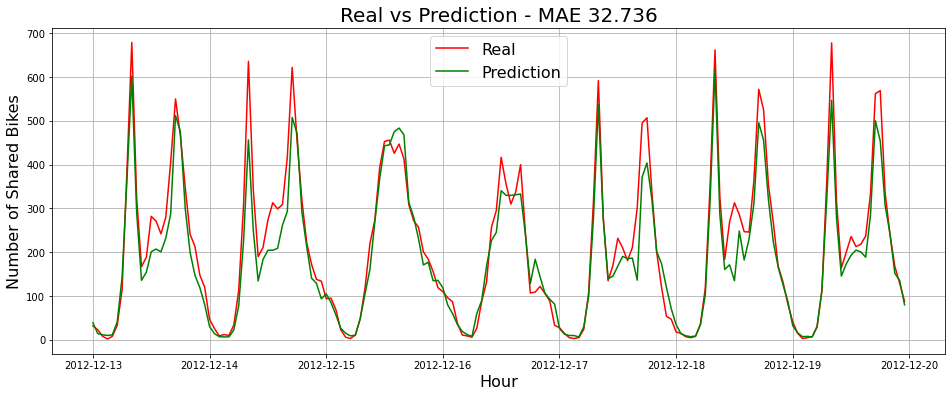

In [21]:
plot_results(mae, y_test, predictions)

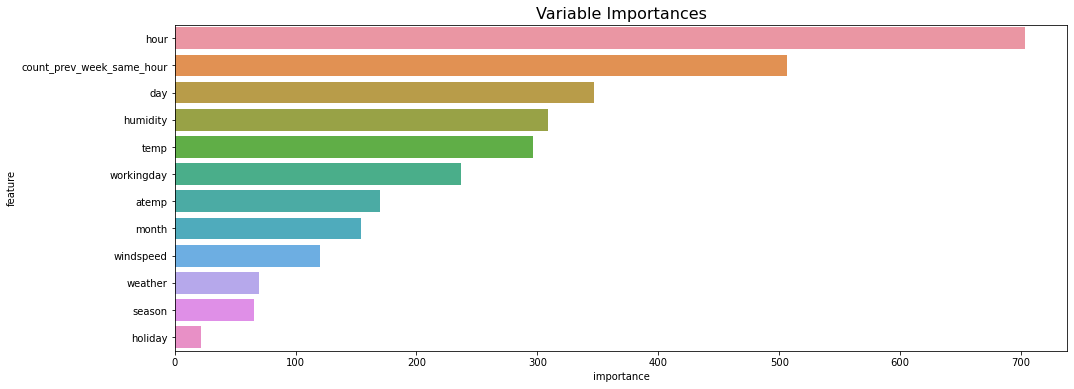

In [22]:
plot_variable_importance(model)